In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scanpy as sc
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import scgpt as scg
import sys
from pathlib import Path

In [4]:
# make GPU visible
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.is_available()

True

In [5]:
import random

def set_random_seed(seed_value=42):
    """Set random seed for reproducibility."""
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using CUDA
    np.random.seed(seed_value)
    random.seed(seed_value)

# Call the function before creating your Lightning module, data module, or initializing your data loaders
set_random_seed()

# data: props_exp_scvi_tsubtypes_0.25vs0.1c_dirstr30_1000pts

In [6]:
h5ad_loc="/data/rna_rep_learning/scset/props_exp_scvi_tsubtypes_0.25vs0.1c_dirstr30_1000pts.h5ad"

In [7]:
# read in data from cache
adata = sc.read_h5ad(h5ad_loc)

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [36]:
adata

AnnData object with n_obs × n_vars = 445575 × 21507
    obs: 'orig_cellbarcode', 'patient_orig', 'celltype', 'Tcellsubtype', 'group', 'patient'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'highly_variable_rank', 'variances', 'variances_norm', 'index', 'id_in_vocab'
    uns: 'celltype_colors', 'group_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_scGPT'
    varm: 'PCs'
    layers: 'counts', 'lognorm'
    obsp: 'connectivities', 'distances'

In [46]:
adata.obs.rename(columns={'celltype':'cell_type'}, inplace=True)

### embed cells using scGPT

In [9]:
model_dir = Path("/data/rna_rep_learning/scGPT/scGPT_human")

In [15]:
adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col="index",
    batch_size=64,
    return_new_adata=False,
)

scGPT - INFO - match 21507/23776 genes in vocabulary of size 60697.


Embedding cells: 100%|███████████████████████████████████████████████████████████████████████████████| 6963/6963 [08:58<00:00, 12.92it/s]
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [17]:
#save this new adata
adata.write("/data/rna_rep_learning/luca_salcher2022/props_exp_scvi_tsubtypes_0.25vs0.1c_dirstr30_1000pts_w_scGPT_embeds.h5ad")

In [ ]:
adata = sc.read_h5ad("/data/rna_rep_learning/luca_salcher2022/props_exp_scvi_tsubtypes_0.25vs0.1c_dirstr30_1000pts_w_scGPT_embeds.h5ad")

In [46]:
adata.obs.rename(columns={'celltype':'cell_type'}, inplace=True)

## check if by usual stats tests there is a diff between groups for each cell type proportion

In [7]:
ct_counts = adata.obs.groupby(["patient","cell_type"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'celltypecounts'}).reset_index().set_index("patient")

In [8]:
person_counts = adata.obs.groupby(["patient"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'person_counts'})

In [9]:
toplot = ct_counts.merge(person_counts, right_index=True, left_index=True).merge(adata.obs[['patient','group']], left_index=True, right_on="patient")

In [10]:
toplot['celltypefracs'] = toplot['celltypecounts']/toplot['person_counts']

In [11]:
toplot = toplot[["cell_type", "patient", "group", "celltypefracs"]].drop_duplicates()
toplot

,celltype,patient,group,celltypefracs
0,B-cells,sim_pt1,group1,0.334052
0,CD14+ Monocytes,sim_pt1,group1,0.185345
0,CD4 Cytotoxic,sim_pt1,group1,0.047414
0,CD8 Cytotoxic,sim_pt1,group1,0.256466
0,Helper 1,sim_pt1,group1,0.118534
...,...,...,...,...
0,CD14+ Monocytes,sim_pt1000,group2,0.119266
0,CD4 Cytotoxic,sim_pt1000,group2,0.213303
0,CD8 Cytotoxic,sim_pt1000,group2,0.119266
0,Helper 1,sim_pt1000,group2,0.174312


[Text(0, 0, 'B-cells'),
 Text(1, 0, 'CD14+ Monocytes'),
 Text(2, 0, 'CD4 Cytotoxic'),
 Text(3, 0, 'CD8 Cytotoxic'),
 Text(4, 0, 'Helper 1'),
 Text(5, 0, 'Memory Cytotoxic')]

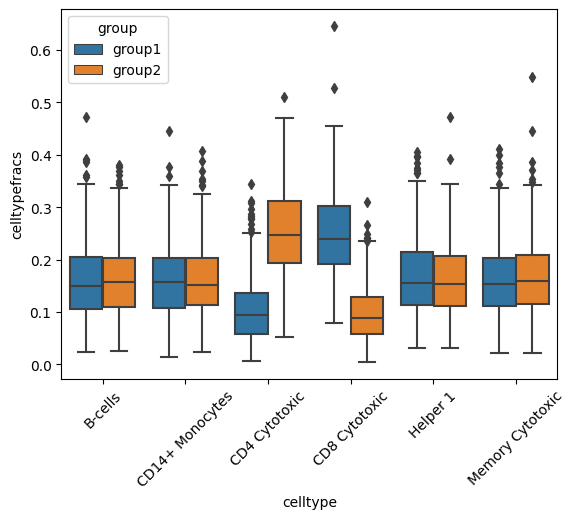

In [12]:
ax = sns.boxplot(data=toplot, x="celltype", y="celltypefracs", hue="group")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


## define sample pool, target, X, splits for this task

### define sample_pool for this target

In [18]:
sample_col = 'patient'
target_col = 'group'

In [19]:
adata.obs[[sample_col, target_col]].drop_duplicates()[target_col].value_counts()

group
group1    500
group2    500
Name: count, dtype: int64

In [21]:
sample_pool = adata.obs[sample_col].drop_duplicates()
print(len(sample_pool))

1000


In [66]:
sample_pool

0       sim_pt1
0       sim_pt2
0       sim_pt3
0       sim_pt4
0       sim_pt5
        ...    
0     sim_pt996
0     sim_pt997
0     sim_pt998
0     sim_pt999
0    sim_pt1000
Name: patient, Length: 1000, dtype: category
Categories (1000, object): ['sim_pt1', 'sim_pt2', 'sim_pt3', 'sim_pt4', ..., 'sim_pt997', 'sim_pt998', 'sim_pt999', 'sim_pt1000']

### define target, and limit/order by sample_pool

In [22]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [23]:
labels

array(['group1', 'group2'], dtype=object)

In [24]:
targets.value_counts()/len(targets)

0    0.5
1    0.5
Name: count, dtype: float64

### 10 fold nested cross validation (cv outer loop)

In [28]:
adata.obs[["patient_orig","patient","group"]].drop_duplicates()#.groupby('patient_orig').group.value_counts()

,patient_orig,patient,group
0,MM-5,sim_pt1,group1
1,SMMh-4,sim_pt1,group1
2,NBM-11,sim_pt1,group1
3,SMMl-1,sim_pt1,group1
22,SMMl-2,sim_pt1,group1
...,...,...,...
206,MM-3,sim_pt1000,group2
294,SMMh-9,sim_pt1000,group2
326,SMMh-8,sim_pt1000,group2
407,NBM-1,sim_pt1000,group2


In [29]:
adata.obs.groupby("patient").patient_orig.value_counts()

/tmp/ipykernel_1997828/2283675068.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("patient").patient_orig.value_counts()


patient     patient_orig
sim_pt1     MM-5            72
            SMMh-4          58
            NBM-10          39
            SMMl-2          24
            MM-3            23
                            ..
sim_pt1000  MGUS-2           2
            SMMh-2           1
            NBM-3            0
            NBM-4            0
            MM-6             0
Name: count, Length: 32000, dtype: int64

In [31]:
skf = StratifiedKFold(n_splits=10)
splits = list(skf.split(np.zeros(len(targets)), targets))

In [33]:
for (train_index, test_index) in splits:
    #print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100




## create pseudobulk embeddings to use downstream

In [35]:
pbulk_embs = {}

#### scGPT

In [37]:
emb_name = 'X_scGPT'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs[emb_name] = pseudobulk_input

/tmp/ipykernel_1997828/2538767356.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### scGPT -> 40 PCs

In [41]:
emb_name = 'X_scGPT'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs['scgpt_40PCs'] = pseudobulk_input

/tmp/ipykernel_1997828/1233326641.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### PCA

In [44]:
emb_name = 'X_pca'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs[emb_name] = pseudobulk_input

/tmp/ipykernel_1997828/49313768.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### cell type props

In [48]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df
pbulk_embs['ct_props'] = pseudobulk_input

/tmp/ipykernel_1997828/702871507.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")


#### cell type props + mean embedding based on scGPT

In [62]:
#get mean embedding per cell type

emb_name = 'X_scGPT'

# get mean embedding per sample+cell_type -- had to do some reindexing for this dataset specifically
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name]).merge(adata.obs[[sample_col,'cell_type']].reset_index().drop(columns=["index"]), right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_1997828/4206657813.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name]).merge(adata.obs[[sample_col,'cell_type']].reset_index().drop(columns=["index"]), right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [63]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPTfull'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

#### cell type props + mean embedding based on PCA

In [64]:
#get mean embedding per cell type

emb_name = 'X_pca'
pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

# get mean embedding per sample+cell_type -- had to do some reindexing for this dataset specifically
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name]).merge(adata.obs[[sample_col,'cell_type']].reset_index().drop(columns=["index"]), right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['pca_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_1997828/3998037576.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name]).merge(adata.obs[[sample_col,'cell_type']].reset_index().drop(columns=["index"]), right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [65]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_PCA'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

### limit/order pseudobulk embeddings by sample_pool

In [68]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

## calculate heuristic baseline performance on these splits

not including majority class per study as a baseline, since we shouldn't have study based batch effects affecting performance using our GroupKFold!

In [69]:
val_majclass_bline_accs= []

for (train_index, val_index) in splits:
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))

print("baseline accuracy on K val sets: ", np.around(val_majclass_bline_accs,3))
print("mean accuracy: ", np.round(np.mean(val_majclass_bline_accs),3))

baseline accuracy on K val sets:  [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
mean accuracy:  0.5


## Evaluate models using nested CV

In [76]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def nested_kfold_eval(pseudobulk_input, targets, splits, model, param_grid):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(model, param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=skf)
    
    print("Nested CV Score: ", np.round(nested_score.mean(),3))
    
    return nested_score

In [71]:
# set up a dict with models and hparams to test

model_param_dict = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors':np.arange(10)+1}),
    'random_forest' : (RandomForestClassifier(), {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}),
    'logistic_regression': (LogisticRegression(max_iter=500), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]})
}


In [78]:
task1_results = {}
for model in model_param_dict:
    print("--------- {} ----------".format(model))
    task1_results[model] = {}
    for emb in this_pbulk_embs: #our proxies arent meaningful when there is only one cell type
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        task1_results[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- KNN ----------
embedding:  X_scGPT
shape of embedding:  (1000, 512)
Nested CV Score:  0.531


embedding:  scgpt_40PCs
shape of embedding:  (1000, 40)
Nested CV Score:  0.539


embedding:  X_pca
shape of embedding:  (1000, 50)
Nested CV Score:  0.816


embedding:  ct_props
shape of embedding:  (1000, 6)
Nested CV Score:  0.926


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (1000, 3078)
Nested CV Score:  0.926


embedding:  ct_fracs_means_PCA
shape of embedding:  (1000, 306)
Nested CV Score:  0.581




--------- random_forest ----------
embedding:  X_scGPT
shape of embedding:  (1000, 512)
Nested CV Score:  0.634


embedding:  scgpt_40PCs
shape of embedding:  (1000, 40)
Nested CV Score:  0.645


embedding:  X_pca
shape of embedding:  (1000, 50)
Nested CV Score:  0.899


embedding:  ct_props
shape of embedding:  (1000, 6)
Nested CV Score:  0.915


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (1000, 3078)
Nested CV Score:  0.901


embedding:  ct_fracs_mea

# data: props_exp_scvi_tsubtypes_0.1vs0.05c_dirstr30_1000pts

In [79]:
h5ad_loc="/data/rna_rep_learning/scset/props_exp_scvi_tsubtypes_0.1vs0.05_dirstr30_1000pts.h5ad"

In [80]:
# read in data from cache
adata = sc.read_h5ad(h5ad_loc)

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [98]:
adata.obs.rename(columns={'celltype':'cell_type'}, inplace=True)

### embed cells using scGPT

In [7]:
import scgpt as scg
import sys
from pathlib import Path

In [8]:
model_dir = Path("/data/rna_rep_learning/scGPT/scGPT_human")

In [9]:
# scGPT code assumes counts are stored in X, so move things around accordingly
adata.X = adata.layers['counts']

In [10]:
adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col="index",
    cell_type_key="celltype",
    #obs_to_save=adata.obs.columns,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=False,
)

scGPT - INFO - match 21507/23776 genes in vocabulary of size 60697.


Embedding cells: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6963/6963 [08:03<00:00, 14.39it/s]
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
#save this new adata
adata.write("/data/rna_rep_learning/luca_salcher2022/props_exp_scvi_tsubtypes_0.1vs0.05_dirstr30_1000pts_w_scGPT_embeds.h5ad")

In [81]:
adata = sc.read_h5ad("/data/rna_rep_learning/luca_salcher2022/props_exp_scvi_tsubtypes_0.1vs0.05_dirstr30_1000pts_w_scGPT_embeds.h5ad")

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [46]:
adata.obs.rename(columns={'celltype':'cell_type'}, inplace=True)

#### Check that these scGPT embeddings look reasonable

In [12]:
sc.pp.neighbors(adata, use_rep="X_scGPT")

In [ ]:
sc.tl.umap(adata)

/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


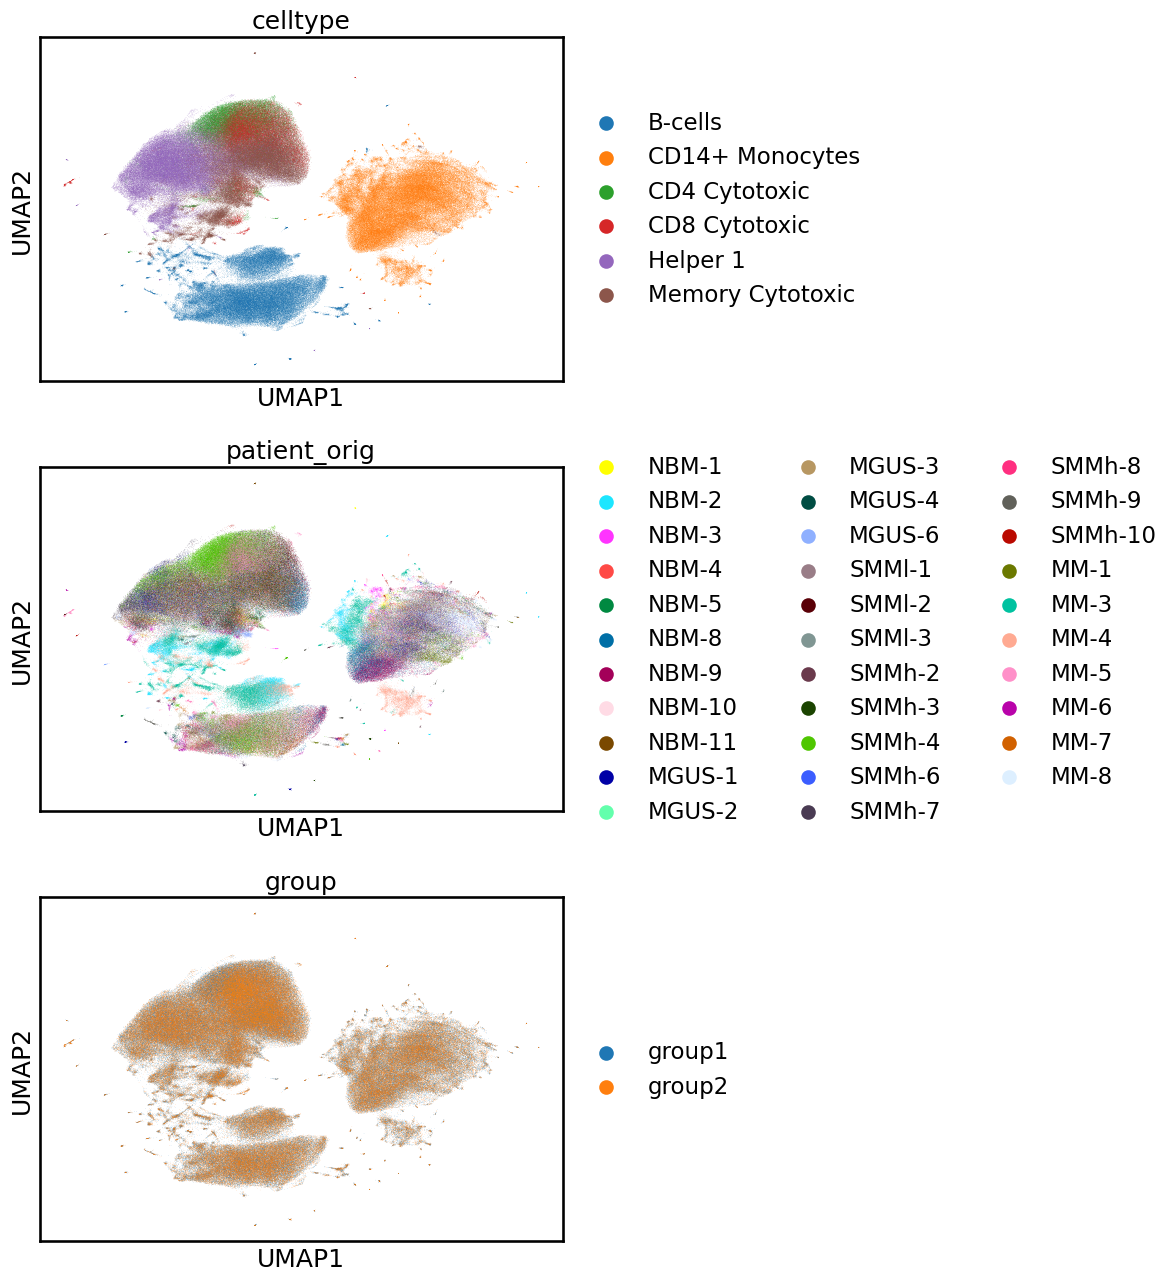

In [21]:
sc.pl.umap(adata, color=["cell_type","patient_orig","group"], ncols=1)

## check if by usual stats tests there is a diff between groups for each cell type proportion

In [16]:
ct_counts = adata.obs.groupby(["patient","cell_type"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'celltypecounts'}).reset_index().set_index("patient")

In [17]:
person_counts = adata.obs.groupby(["patient"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'person_counts'})

In [18]:
toplot = ct_counts.merge(person_counts, right_index=True, left_index=True).merge(adata.obs[['patient','group']], left_index=True, right_on="patient")

In [19]:
toplot['celltypefracs'] = toplot['celltypecounts']/toplot['person_counts']

In [20]:
toplot = toplot[["cell_type", "patient", "group", "celltypefracs"]].drop_duplicates()
toplot

,celltype,patient,group,celltypefracs
0,B-cells,sim_pt1,group1,0.390086
0,CD14+ Monocytes,sim_pt1,group1,0.286638
0,CD4 Cytotoxic,sim_pt1,group1,0.047414
0,CD8 Cytotoxic,sim_pt1,group1,0.028017
0,Helper 1,sim_pt1,group1,0.140086
...,...,...,...,...
0,CD14+ Monocytes,sim_pt1000,group2,0.220183
0,CD4 Cytotoxic,sim_pt1000,group2,0.084862
0,CD8 Cytotoxic,sim_pt1000,group2,0.087156
0,Helper 1,sim_pt1000,group2,0.155963


[Text(0, 0, 'B-cells'),
 Text(1, 0, 'CD14+ Monocytes'),
 Text(2, 0, 'CD4 Cytotoxic'),
 Text(3, 0, 'CD8 Cytotoxic'),
 Text(4, 0, 'Helper 1'),
 Text(5, 0, 'Memory Cytotoxic')]

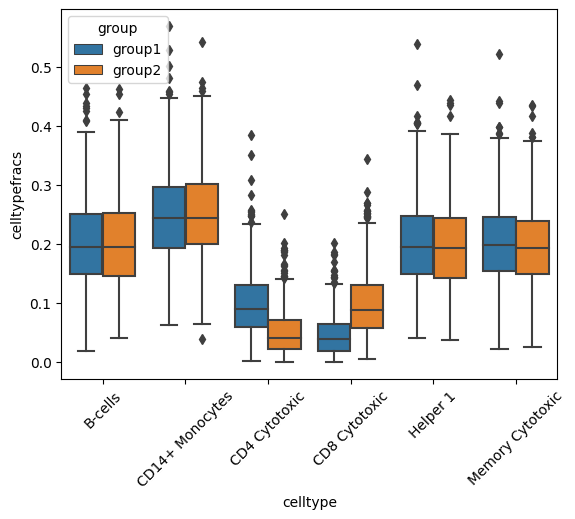

In [21]:
ax = sns.boxplot(data=toplot, x="cell_type", y="celltypefracs", hue="group")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


## define sample pool, target, X, splits for this task

### define sample_pool for this target

In [82]:
sample_col = 'patient'
target_col = 'group'

In [83]:
adata.obs[[sample_col, target_col]].drop_duplicates()[target_col].value_counts()

group
group1    500
group2    500
Name: count, dtype: int64

In [84]:
sample_pool = adata.obs[sample_col].drop_duplicates()
print(len(sample_pool))

1000


In [85]:
sample_pool

0       sim_pt1
0       sim_pt2
0       sim_pt3
0       sim_pt4
0       sim_pt5
        ...    
0     sim_pt996
0     sim_pt997
0     sim_pt998
0     sim_pt999
0    sim_pt1000
Name: patient, Length: 1000, dtype: category
Categories (1000, object): ['sim_pt1', 'sim_pt2', 'sim_pt3', 'sim_pt4', ..., 'sim_pt997', 'sim_pt998', 'sim_pt999', 'sim_pt1000']

### define target, and limit/order by sample_pool

In [86]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [87]:
labels

array(['group1', 'group2'], dtype=object)

In [88]:
targets.value_counts()/len(targets)

0    0.5
1    0.5
Name: count, dtype: float64

### 10 fold nested cross validation (cv outer loop)

In [89]:
adata.obs[["patient_orig","patient","group"]].drop_duplicates()#.groupby('patient_orig').group.value_counts()

,patient_orig,patient,group
0,SMMh-4,sim_pt1,group1
6,MM-5,sim_pt1,group1
8,NBM-11,sim_pt1,group1
9,SMMl-1,sim_pt1,group1
22,NBM-8,sim_pt1,group1
...,...,...,...
177,NBM-9,sim_pt1000,group2
185,MGUS-6,sim_pt1000,group2
215,SMMh-8,sim_pt1000,group2
399,NBM-4,sim_pt1000,group2


In [90]:
adata.obs.groupby("patient").patient_orig.value_counts()

/tmp/ipykernel_1997828/2283675068.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("patient").patient_orig.value_counts()


patient     patient_orig
sim_pt1     SMMh-4          58
            NBM-10          34
            MM-5            32
            MGUS-3          31
            MM-3            31
                            ..
sim_pt1000  MGUS-2           3
            MGUS-6           3
            NBM-4            2
            MM-6             2
            NBM-1            1
Name: count, Length: 32000, dtype: int64

In [91]:
skf = StratifiedKFold(n_splits=10)
splits = list(skf.split(np.zeros(len(targets)), targets))

In [92]:
for (train_index, test_index) in splits:
    #print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100


n samples in train:  900
n samples in test:  100




## create pseudobulk embeddings to use downstream

In [93]:
pbulk_embs = {}

#### scGPT

In [94]:
emb_name = 'X_scGPT'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs[emb_name] = pseudobulk_input

/tmp/ipykernel_1997828/1669887707.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### scGPT -> 40 PCs

In [95]:
emb_name = 'X_scGPT'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs['scgpt_40PCs'] = pseudobulk_input

/tmp/ipykernel_1997828/1955282872.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### PCA

In [96]:
emb_name = 'X_pca'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs[emb_name] = pseudobulk_input

/tmp/ipykernel_1997828/49313768.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### cell type props

In [99]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df
pbulk_embs['ct_props'] = pseudobulk_input

/tmp/ipykernel_1997828/702871507.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")


#### cell type props + mean embedding based on scGPT

In [100]:
#get mean embedding per cell type

emb_name = 'X_scGPT'

# get mean embedding per sample+cell_type -- had to do some reindexing for this dataset specifically
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name]).merge(adata.obs[[sample_col,'cell_type']].reset_index().drop(columns=["index"]), right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_1997828/3176537057.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name]).merge(adata.obs[[sample_col,'cell_type']].reset_index().drop(columns=["index"]), right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [101]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPTfull'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

#### cell type props + mean embedding based on PCA

In [102]:
#get mean embedding per cell type

emb_name = 'X_pca'
pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

# get mean embedding per sample+cell_type -- had to do some reindexing for this dataset specifically
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name]).merge(adata.obs[[sample_col,'cell_type']].reset_index().drop(columns=["index"]), right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['pca_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_1997828/3998037576.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name]).merge(adata.obs[[sample_col,'cell_type']].reset_index().drop(columns=["index"]), right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [103]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_PCA'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

### limit/order pseudobulk embeddings by sample_pool

In [104]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

## calculate heuristic baseline performance on these splits

not including majority class per study as a baseline, since we shouldn't have study based batch effects affecting performance using our GroupKFold!

In [105]:
val_majclass_bline_accs= []

for (train_index, val_index) in splits:
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))

print("baseline accuracy on K val sets: ", np.around(val_majclass_bline_accs,3))
print("mean accuracy: ", np.round(np.mean(val_majclass_bline_accs),3))

baseline accuracy on K val sets:  [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
mean accuracy:  0.5


## Evaluate models using nested CV

In [106]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def nested_kfold_eval(pseudobulk_input, targets, splits, model, param_grid):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(model, param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=skf)
    
    print("Nested CV Score: ", np.round(nested_score.mean(),3))
    
    return nested_score

In [107]:
# set up a dict with models and hparams to test

model_param_dict = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors':np.arange(10)+1}),
    'random_forest' : (RandomForestClassifier(), {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}),
    'logistic_regression': (LogisticRegression(max_iter=500), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]})
}


In [108]:
task1_results = {}
for model in model_param_dict:
    print("--------- {} ----------".format(model))
    task1_results[model] = {}
    for emb in this_pbulk_embs: #our proxies arent meaningful when there is only one cell type
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        task1_results[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- KNN ----------
embedding:  X_scGPT
shape of embedding:  (1000, 512)
Nested CV Score:  0.562


embedding:  scgpt_40PCs
shape of embedding:  (1000, 40)
Nested CV Score:  0.572


embedding:  X_pca
shape of embedding:  (1000, 50)
Nested CV Score:  0.603


embedding:  ct_props
shape of embedding:  (1000, 6)
Nested CV Score:  0.721


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (1000, 3078)
Nested CV Score:  0.714


embedding:  ct_fracs_means_PCA
shape of embedding:  (1000, 306)
Nested CV Score:  0.593




--------- random_forest ----------
embedding:  X_scGPT
shape of embedding:  (1000, 512)
Nested CV Score:  0.663


embedding:  scgpt_40PCs
shape of embedding:  (1000, 40)
Nested CV Score:  0.711


embedding:  X_pca
shape of embedding:  (1000, 50)
Nested CV Score:  0.723


embedding:  ct_props
shape of embedding:  (1000, 6)
Nested CV Score:  0.769


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (1000, 3078)
Nested CV Score:  0.74


embedding:  ct_fracs_mean

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Nested CV Score:  0.774


embedding:  ct_fracs_means_PCA
shape of embedding:  (1000, 306)


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Nested CV Score:  0.655






# data: props_exp_scvi_tsubtypes_0.15vs0.05c_dirstr50_10Kpts

In [6]:
h5ad_loc="/data/rna_rep_learning/scset/synthetic_props_data/props_cd8_vs_cd4_0.05vs0.15_dirconc50_10000patients_HVGonly.h5ad"

In [7]:
# read in data from cache
adata = sc.read_h5ad(h5ad_loc)

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
adata.obs.rename(columns={'celltype':'cell_type'}, inplace=True)

### embed cells using scGPT

In [42]:
import scgpt as scg
import sys
from pathlib import Path

In [43]:
model_dir = Path("/data/rna_rep_learning/scGPT/scGPT_human")

In [44]:
adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col="index",
    batch_size=64,
    return_new_adata=False,
)

scGPT - INFO - match 4524/5000 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69492/69492 [1:20:52<00:00, 14.32it/s]
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [45]:
#save this new adata
adata.write("/data/rna_rep_learning/scset/synthetic_props_data/props_cd8_vs_cd4_0.05vs0.15_dirconc50_10000patients_HVGonly_scGPT.h5ad", compression="gzip")

In [6]:
adata = sc.read_h5ad("/data/rna_rep_learning/scset/synthetic_props_data/props_cd8_vs_cd4_0.05vs0.15_dirconc50_10000patients_HVGonly_scGPT.h5ad")

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


#### Check that these scGPT embeddings look reasonable

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scGPT")

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=["cell_type","patient_orig","group"], ncols=1)

## check if by usual stats tests there is a diff between groups for each cell type proportion

In [11]:
ct_counts = adata.obs.groupby(["patient","cell_type"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'celltypecounts'}).reset_index().set_index("patient")

/tmp/ipykernel_3435938/3927802220.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct_counts = adata.obs.groupby(["patient","cell_type"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'celltypecounts'}).reset_index().set_index("patient")


In [12]:
person_counts = adata.obs.groupby(["patient"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'person_counts'})

/tmp/ipykernel_3435938/3679586629.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_counts = adata.obs.groupby(["patient"]).count().iloc[:,[0]].rename(columns={'orig_cellbarcode':'person_counts'})


In [13]:
toplot = ct_counts.merge(person_counts, right_index=True, left_index=True).merge(adata.obs[['patient','group']], left_index=True, right_on="patient")

In [14]:
toplot['celltypefracs'] = toplot['celltypecounts']/toplot['person_counts']

In [15]:
toplot = toplot[["cell_type", "patient", "group", "celltypefracs"]].drop_duplicates()

/tmp/ipykernel_3435938/2252436649.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


[Text(0, 0, 'B-cells'),
 Text(1, 0, 'CD4 Cytotoxic'),
 Text(2, 0, 'CD8 Cytotoxic'),
 Text(3, 0, 'CD14+ Monocytes'),
 Text(4, 0, 'Helper 1'),
 Text(5, 0, 'Memory Cytotoxic')]

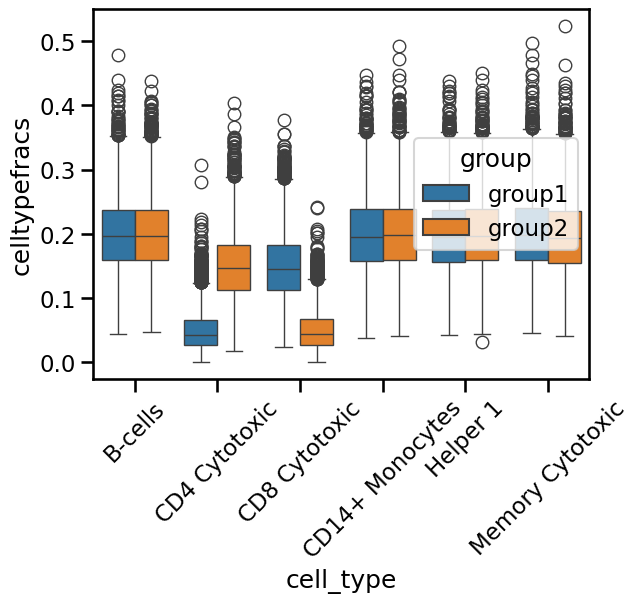

In [16]:
ax = sns.boxplot(data=toplot, x="cell_type", y="celltypefracs", hue="group")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


## define sample pool, target, X, splits for this task

### define sample_pool for this target

In [7]:
sample_col = 'patient'
target_col = 'group'

In [8]:
adata.obs[[sample_col, target_col]].drop_duplicates()[target_col].value_counts()

group
group1    5000
group2    5000
Name: count, dtype: int64

In [9]:
sample_pool = adata.obs[sample_col].drop_duplicates()
print(len(sample_pool))

10000


### define target, and limit/order by sample_pool

In [10]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [11]:
labels

array(['group1', 'group2'], dtype=object)

In [12]:
targets.value_counts()/len(targets)

0    0.5
1    0.5
Name: count, dtype: float64

### 10 fold nested cross validation (cv outer loop)

In [13]:
adata.obs[["patient_orig","patient","group"]].drop_duplicates()#.groupby('patient_orig').group.value_counts()

,patient_orig,patient,group
0,NBM-11,sim_pt1,group1
1,SMMh-4,sim_pt1,group1
7,SMMl-2,sim_pt1,group1
9,SMMl-1,sim_pt1,group1
14,SMMl-3,sim_pt1,group1
...,...,...,...
298,SMMh-2,sim_pt10000,group2
330,SMMh-9,sim_pt10000,group2
390,NBM-3,sim_pt10000,group2
399,NBM-4,sim_pt10000,group2


In [14]:
skf = StratifiedKFold(n_splits=10)
splits = list(skf.split(np.zeros(len(targets)), targets))

In [15]:
for (train_index, test_index) in splits:
    #print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

n samples in train:  9000
n samples in test:  1000


n samples in train:  9000
n samples in test:  1000


n samples in train:  9000
n samples in test:  1000


n samples in train:  9000
n samples in test:  1000


n samples in train:  9000
n samples in test:  1000


n samples in train:  9000
n samples in test:  1000


n samples in train:  9000
n samples in test:  1000


n samples in train:  9000
n samples in test:  1000


n samples in train:  9000
n samples in test:  1000


n samples in train:  9000
n samples in test:  1000




## create pseudobulk embeddings to use downstream

In [16]:
pbulk_embs = {}

#### scGPT

In [ ]:
emb_name = 'X_scGPT'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs[emb_name] = pseudobulk_input

#### scGPT -> 40 PCs

In [ ]:
emb_name = 'X_scGPT'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs['scgpt_40PCs'] = pseudobulk_input

#### PCA

In [ ]:
emb_name = 'X_pca'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs[emb_name] = pseudobulk_input

#### pseudobulk of lognorm counts for 1000 HVGs (5000 took wayyy too long for models to train)

In [ ]:
sc.pp.highly_variable_genes(adata, layer="counts", n_top_genes=1000, flavor='seurat_v3')

In [ ]:
emb_name = "hvg_lognorm"

## Input
pseudobulk_input = pd.DataFrame(adata.layers['lognorm'][:,adata.var.highly_variable].todense(), index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs[emb_name] = pseudobulk_input

#### pseudobulk of scaled counts for 1000 HVGs (5000 took wayyy too long for models to train)

In [ ]:
#only if not already run above
#sc.pp.highly_variable_genes(adata, layer="counts", n_top_genes=1000, flavor='seurat_v3')

In [ ]:
emb_name = "hvg_scaled"

## Input
pseudobulk_input = pd.DataFrame(adata.X[:,adata.var.highly_variable], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

pbulk_embs[emb_name] = pseudobulk_input

#### cell type props - acts as oracle for this experiment

In [ ]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df
pbulk_embs['ct_props'] = pseudobulk_input

### limit/order pseudobulk embeddings by sample_pool

In [ ]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

## calculate heuristic baseline performance on these splits

not including majority class per study as a baseline, since we shouldn't have study based batch effects affecting performance using our GroupKFold!

In [24]:
val_majclass_bline_accs= []

for (train_index, val_index) in splits:
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))

print("baseline accuracy on K val sets: ", np.around(val_majclass_bline_accs,3))
print("mean accuracy: ", np.round(np.mean(val_majclass_bline_accs),3))

baseline accuracy on K val sets:  [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
mean accuracy:  0.5


## Evaluate models using nested CV

In [ ]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def nested_kfold_eval(pseudobulk_input, targets, splits, model, param_grid):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(model, param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=skf)
    
    print("Nested CV Score: ", np.round(nested_score.mean(),3))
    
    return nested_score

In [ ]:
# set up a dict with models and hparams to test

model_param_dict = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors':np.arange(10)+1}),
    'random_forest' : (RandomForestClassifier(), {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}),
    'logistic_regression_l2': (LogisticRegression(max_iter=500), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]}),
    'logistic_regression_l1': (LogisticRegression(max_iter=500, penalty='l1', solver='liblinear'), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]})
}


In [ ]:
task1_results = {}
for model in ['logistic_regression_l2', 'logistic_regression_l1']:
    print("--------- {} ----------".format(model))
    task1_results[model] = {}
    for emb in this_pbulk_embs:
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        task1_results[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- logistic_regression_l2 ----------
embedding:  X_scGPT
shape of embedding:  (10000, 512)
Nested CV Score:  0.5


embedding:  scgpt_40PCs
shape of embedding:  (10000, 40)
Nested CV Score:  0.5


embedding:  X_pca
shape of embedding:  (10000, 50)
Nested CV Score:  0.917


embedding:  hvg_lognorm
shape of embedding:  (10000, 1000)


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Nested CV Score:  0.902


embedding:  hvg_scaled
shape of embedding:  (10000, 1000)
Nested CV Score:  0.901


embedding:  ct_props
shape of embedding:  (10000, 6)
Nested CV Score:  0.949




--------- logistic_regression_l1 ----------
embedding:  X_scGPT
shape of embedding:  (10000, 512)


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit

In [ ]:
task1_results = {}
for model in ['random_forest']:
    print("--------- {} ----------".format(model))
    task1_results[model] = {}
    for emb in this_pbulk_embs:
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        task1_results[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")